

## This notebook experiments on randomly selects 500 rows out of full dataset and run ML based on these data



In [1]:
import pandas as pd
import numpy as np

In [2]:
X_2house = pd.read_csv('/wgdisk/ho0338/ek79/Tien/X_2house_v0.csv')
X_2house=X_2house.drop(columns=['Unnamed: 0'])
X_2house.index.rename('Order', inplace=True)

In [3]:
y_2house = np.load('y_2house.npy')

### To randomly select samples out of full dataset

In [4]:
from random import sample
# create random index
rindex =  np.array(sample(range(len(X_2house)), 500))
print(rindex[0:10])
# get 10 random rows from df
X_2hrand = X_2house.iloc[rindex]

[ 852929 2358793 1548895  857029 3394278  350783 3744397  997920 2063266
 2341951]


In [5]:
X_2hrand.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch_2,Pool Area_2,Pool QC_2,Fence_2,Misc Feature_2,Misc Val_2,Mo Sold_2,Yr Sold_2,Sale Type_2,Sale Condition_2
Order,,,,,,,,,,,,,,,,,,,,,
852929,30.0,8.0,66.0,8712.0,0.0,1.0,3.0,3.0,4.0,0.0,...,0.0,0.0,-1.0,4.0,0.0,0.0,6.0,2008.0,0.0,3.0
2358793,60.0,4.0,0.0,9839.0,1.0,1.0,0.0,3.0,4.0,1.0,...,0.0,0.0,-1.0,4.0,0.0,0.0,7.0,2006.0,4.0,1.0
1548895,20.0,4.0,80.0,9600.0,1.0,1.0,3.0,3.0,4.0,4.0,...,0.0,0.0,-1.0,4.0,0.0,0.0,6.0,2007.0,0.0,3.0
857029,120.0,6.0,44.0,3811.0,1.0,1.0,0.0,1.0,4.0,0.0,...,0.0,0.0,-1.0,2.0,0.0,0.0,7.0,2006.0,0.0,2.0
3394278,20.0,4.0,77.0,9278.0,1.0,1.0,3.0,3.0,4.0,2.0,...,0.0,0.0,-1.0,2.0,0.0,0.0,7.0,2007.0,0.0,3.0


In [6]:
y_2rand=y_2house[rindex]

In [7]:
print('dimension of X_input:',X_2hrand.shape)
print('dimension of y_input:',y_2rand.shape)

dimension of X_input: (500, 158)
dimension of y_input: (500,)


### Set up the train-test split in sklearn

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_2hrand, y_2rand, test_size=0.5, random_state=12)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(250, 158)
(250,)
(250, 158)
(250,)


### Set up the Xgboost model

In [10]:
import xgboost as xgb
xgdmat=xgb.DMatrix(X_train,y_train)

In [11]:
my_params={'eta':0.1,'seed':12,'objective':'reg:linear','max_depth':4,'min_child_weight':2}

In [12]:
RD_Gb_model0=xgb.train(my_params,xgdmat)

In [13]:
tesdmat=xgb.DMatrix(X_test)
y_pred_test_xgb=RD_Gb_model0.predict(tesdmat)
traindmat=xgb.DMatrix(X_train)
y_pred_train_xgb=RD_Gb_model0.predict(traindmat)

In [14]:
for i in range(len(y_pred_train_xgb)):
    if i < 10:
        print(y_pred_train_xgb[i],y_train[i])

-4935.98 4550.0
-45752.2 -102650.0
-52047.3 -100000.0
-168860.0 -356000.0
-10105.5 -17500.0
-85418.3 -133000.0
-69870.8 -121500.0
35898.4 74000.0
31723.1 47400.0
-9046.92 21000.0


In [15]:
# access several benchmark RMSE for reference:
from sklearn import metrics
print('R^2 score(training):',metrics.r2_score(y_train, y_pred_train_xgb))
print('R^2 score:',metrics.r2_score(y_test, y_pred_test_xgb))
print('MSE score(training):',metrics.mean_squared_error(y_train, y_pred_train_xgb))
print('MAE score(training):',metrics.mean_absolute_error(y_train, y_pred_train_xgb))
print('MSE score:',metrics.mean_squared_error(y_test, y_pred_test_xgb))
print('MAE score:',metrics.mean_absolute_error(y_test, y_pred_test_xgb))

R^2 score(training): 0.752138083076
R^2 score: 0.575488705429
MSE score(training): 3231150284.59
MAE score(training): 41958.727428
MSE score: 6095353803.46
MAE score: 55405.6850332


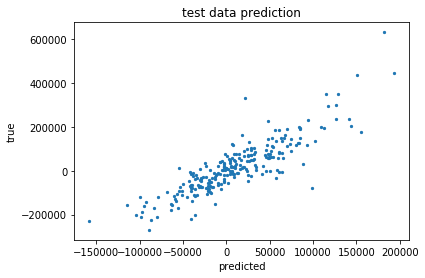

In [17]:
## Plotting the predicted price difference and the true price difference
import matplotlib.pyplot as plt
plt.scatter(y_pred_test_xgb,y_test, s=5)
plt.title('test data prediction')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

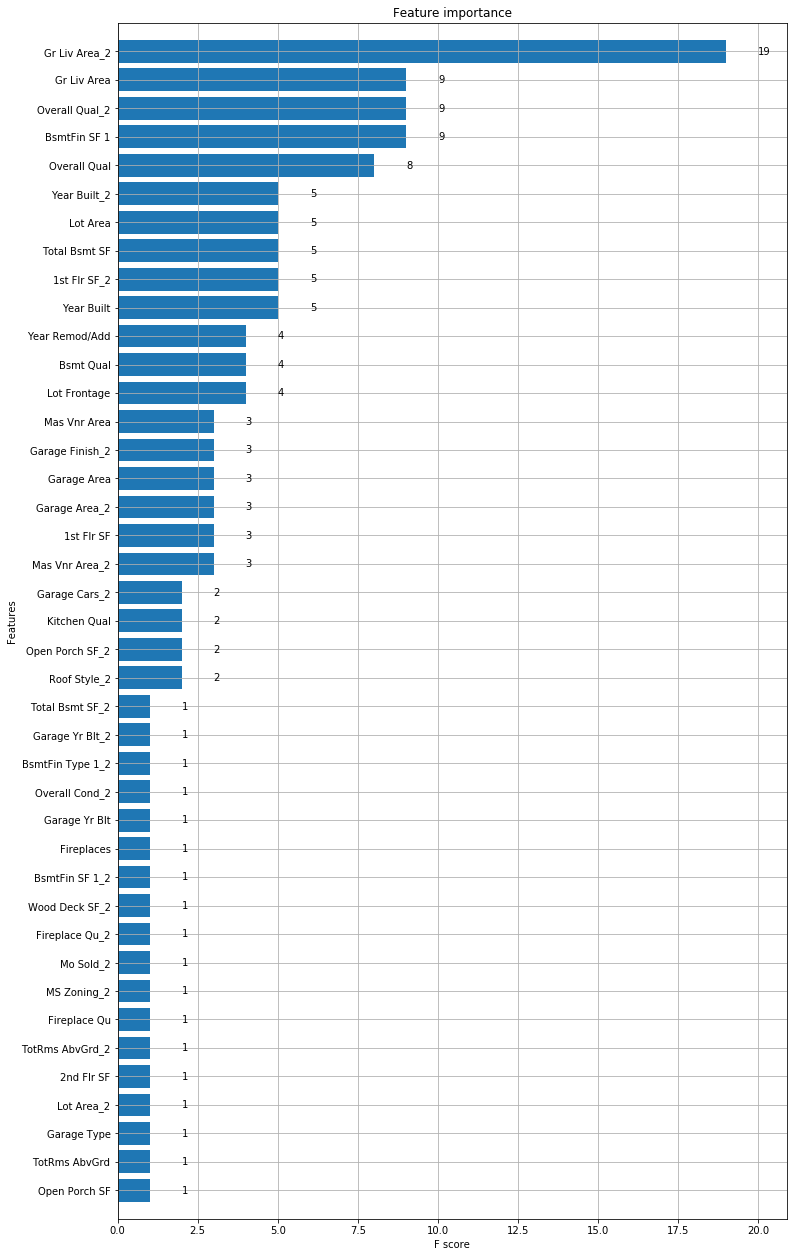

In [18]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12,22))
xgb.plot_importance(RD_Gb_model0, max_num_features=158, height=0.8, ax=ax)
plt.show()

### Do cross-validation to check performance of this model

# import numpy as np
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=20)
k_fold.get_n_splits(X_train)
scores = np.sqrt(-1*cross_val_score(RD_RF_model0, X_train, y_train,verbose=10, cv=20,scoring = 'neg_mean_squared_error'))
print('Cross-validated scores:', scores)

In [19]:
from scipy import stats
stats.describe(scores)

NameError: name 'scores' is not defined

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


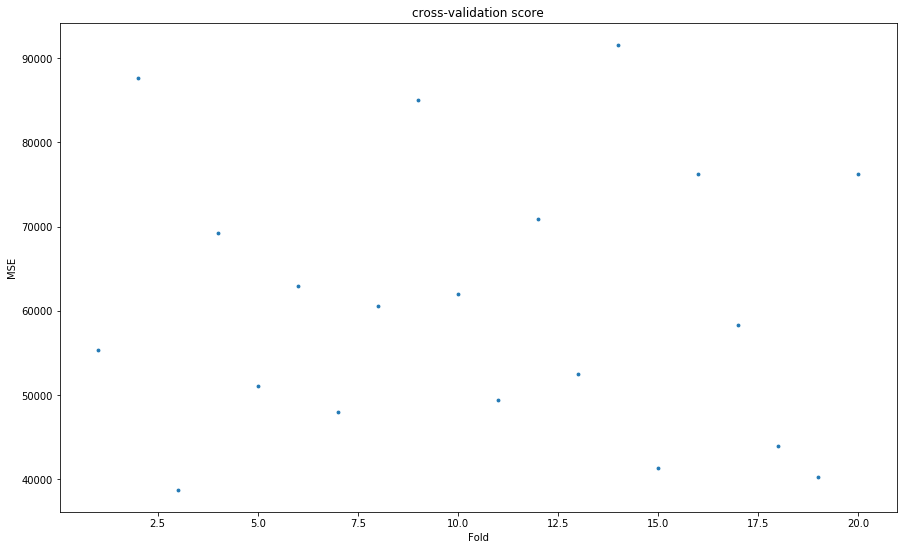

In [25]:
## Plot the variation of the cross-validation scores
stp=np.array([x for x in range(1,21)])
print(stp)
fig = plt.figure(figsize=(15,9))
ax = plt.gca()
ax.scatter(stp,scores,s=8)
plt.title('cross-validation score')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.show()

### plot the error ratio based on the true price

array([201])

In [48]:
# load back index of y_test by X_test order id
ind=X_test.index
ind = list(ind)
price_house = np.load('Sale_Price.npy')
# reconstruct the base price of the house
base_p = np.empty([0,1])
for i in range(len(price_house)):
    ct = len(price_house)-i-1
    tmp_arr = np.ones(ct)*price_house[i]
    base_p = np.append(base_p,tmp_arr)

In [49]:
print(X_2house.shape)
print(y_2house.shape)

(4290985, 158)
(4290985,)


In [50]:
print(base_p.shape)

(4290985,)


In [51]:
base_ph = base_p[ind]
err=(y_pred_test_xgb-y_test)/base_ph

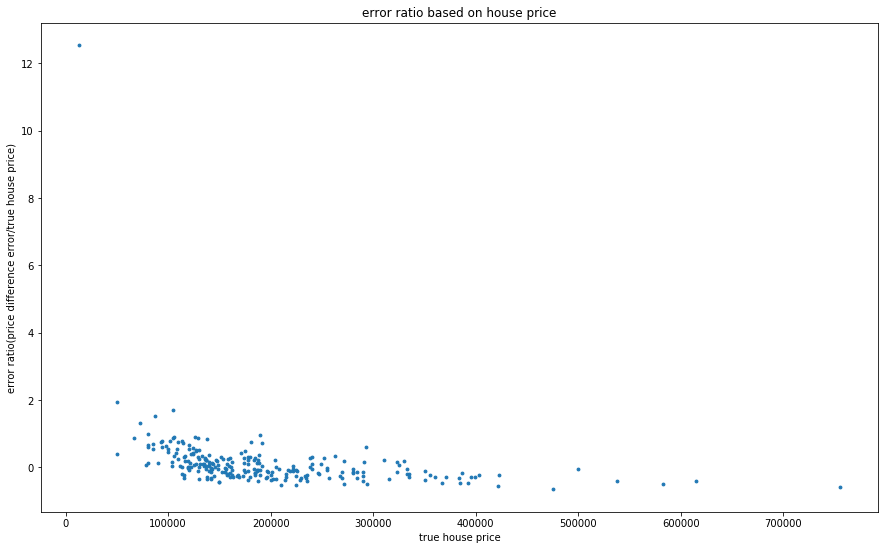

In [53]:
fig = plt.figure(figsize=(15,9))
ax = plt.gca()
ax.scatter(base_ph,err,s=8)
plt.title('error ratio based on house price')
plt.xlabel('true house price')
plt.ylabel('error ratio(price difference error/true house price)')
plt.show()